# 08-2 합성곱 신경망을 사용한 이미지 분류
##### 케라스 API를 사용해 합성곱 신경망 모델을 만들어 패션 MNIST이미지를 분류하는 방법을 배웁니다.

- 앞서 합성곱, 필터, 패딩, 스트라이드, 풀링 등을 익힘
- 텐서플로를 사용하면 합성곱, 패딩, 풀링 크기를 직접 계산할 필요 없음
- 복잡한 계산은 케라스 API에 위임하고 사용자는 직관적으로 신경망 설계 가능(하지만 동작 원리를 터득하면 좋음)
- 이번 절에서는 텐서플로 케라스 API로 7장에서 만들었던 패션 MNIST 데이터를 합성곱 신경망으로 분류해보려 함
- 패션 MNIST 데이터 분류하는데 합성곱의 아이디어가 정말 도움되는지 확인

### 패션MINST 데이터 불러오기
- 주피터 노트북에서 케라스 API 사용하여 패션 MNIST 데이터를 불러오고 전처리 함
  - 데이터 스케일을 0~255 사이에서 0~1 사이로 바꾸고 훈련 / 검증 세트로 나눔
  - 차이점 :
    - 완전 연결 신경망에서는 입력 이미지를 밀집층에 연결하기 위해 일렬로 펼침 (reshape(), Flatten 사용)
    - 합성곱 신경망은 2차원 이미지를 그대로 사용하기 때문에 일렬로 펼치지 않음
  - 다만 입력 이미지는 항상 깊이 (채널) 차원이 있어야 함
  - 흑백 이미지의 경우 채널 차원이 없는 2차원 배열이지만 Conv2D 층을 사용하기 위해 마지막에 이 채널 차원을 추가해야 함
  - reshape() 메서드로 전체 배열 차원을 유지하며 차원 추가 가능

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

2024-01-08 20:25:36.530350: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


- 이제 (48000, 28, 28) 크기의 train_input이 (48000, 28, 28, 1) 크기인 train_scaled가 됨

### 합성곱 신경망 만들기
- 전형적인 합성곱 신경망 구조는 합성곱 층으로 이미지에서 특징을 감지한 후 밀집층으로 클래스에 따른 분류 확률을 계산
- 케라스 Sequential 클래스를 사용해 순서대로 이 구조를 정의해보자
- SEquential 클래스 객체를 만들고 첫 번째 합성곱 층인 Conv2D를 추가
- add() 메서드를 사용해 층을 하나씩 차례대로 추가해봄

In [4]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(28,28,1)))

- 위 합성곱 층은 32개의 필터 사용
- 커널의 크기는 (3,3)
- 렐루 활성화 함수 사용
- 세임 패딩 사용
- 케라스 신경망 모델의 첫 번째 층에서 입력의 차원을 지정해주어야 함 (28,28,1)
- 이제 풀링 층 추가
- Conv2D 클래스의 kernel_size 처럼 가로세로 크기가 같으면 정수 하나로 지정 가능

In [5]:
model.add(keras.layers.MaxPool2D(2))

- 패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용했기 때문에 합성곱 층에서 출력된 특성 맵의 가로세로 크기는 입력과 동일
- (2,2) 풀링을 적용했으므로 특성 맵의 크기는 절반으로 줄어듦
- 합성곱 층에서 32개 필터를 사용했기 때문에 이 특성 맵의 깊이는 32가 됨
- 최대 풀링을 통과한 특성 맵 크기는 (14, 14, 32) (나중에 각 층 출력 크기를 summary() 메서드로 확인)
- 첫 번째 합성곱-풀링 층 다음에 두 번째 합성곱-풀링 층을 추가해보자
- 두 번쨰 합성곱-풀링 층은 첫 번째와 거의 동일 (필터 개수를 64개로 늘린 점만 다름)

In [6]:
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(keras.layers.MaxPool2D(2))

- 첫 번째 합성곱-풀링 층과 마찬가지로 세임 패딩을 사용 (입력 가로세로를 줄이지 않음)
- 이어지는 풀링 층에서 크기를 절반으로 줄임 최종 특성 맵의 크기는 (7,7,64)
- 이제 3차원 특성 맵을 일렬로 펼칠 차례
  - 마지막 10개 뉴런을 가진 (밀집) 출력층에서 확률을 계산하기 때문
  - 특성 맵을 일렬로 펼쳐서 바로 출력층에 전달하지 않고 중간에 하나의 밀집 은닉층을 두어보자
  - (Flatten, Dense 은닉층, Dense 출력층 순서)

In [7]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

- 드롭아웃 층이 들어감 : 은닉층의 과대적합을 막아 성능을 조금 더 개선해 줄 것
- 은닉층 : 100개의 뉴런을 사용하고 활성화 함수는 렐루 함수 사용
- 패션 MNIST 데이터셋은 클래스 10개를 분류하는 다중 분류 문제이므로 마지막 츠으이 활성화 함ㅎ수는 소프트맥스를 사용
- 이제 합성곱 신경망의 구성이 완료
  - 커널, 패딩, 풀링 등으로 케라스 API를 사용해 손쉽게 다양한 구성을 실험해보자
- summary() 메서드로 모델 구조를 확인

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

- summary() 메서드의 출력 결과를 보면 합성곱, 풀링 층의 효과 확인 가능
- 첫 번째 합성곱 층을 통과하며 특성 맵의 깊이는 32가 되고 두 번째 합성곱에서 특성 맵의 크기가 64로 증가
- 특성 맵의 가로세로 크기는 첫 번째 풀링 층에서 절반으로 줄어들고 두 번째 풀링 층에서 다시 절반으로 더 축소 (최종 크기 (7,7,64))
- 완전 연결 신경망에서 했던 것처럼 모델 파라미터 개수를 계산 :
  - 첫 번째 합성곱 층은 32개의 필터가 있고 크기가 (3,3) 깊이가 1 + 절편 :  3 X 3 X 1 X 32 + 32 = 320개 파라미터
  - 두 번쨰 합성곱 층은 64개의 필터가 있고 크기가 (3,3) 깊이가 32 + 절편 : 3 X 3 X 32 X 64 + 64 = 18496개 파라미터
- **층의 구조를 잘 이해하고 있는지 확인은 모델 파라미터 개수 확인하는 것**
- Flatten 클래스에서 (7,7,64) 크기의 특성 맵을 1차원 배열로 펼치면 (3136,) 크기의 배열이 됨
- 이를 100개의 뉴런과 완전히 연결하므로 은닉층의 모델 파라미터 개수는 3,136 X 100 + 100 = 313,700개
- 마찬가지 방식으로 마지막 출력층의 모델 파라미터 개수는 1010개
- 신경망 모델을 잘 구성했고 각 층 파라미터 개수를 검증해보자. 케라스는 plot_model()함수를 제공 (층의 구성을 그림으로 표현)

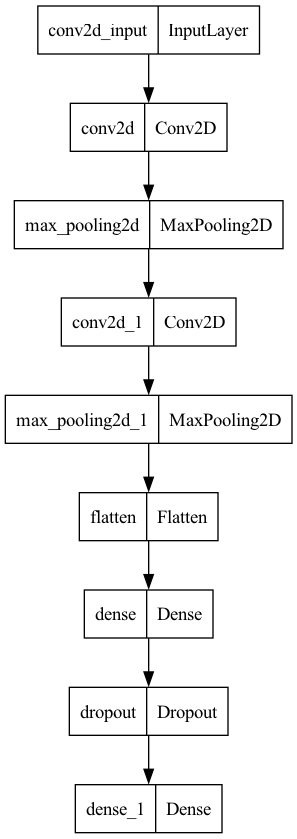

In [9]:
# pip install pydot
# brew install graphviz
keras.utils.plot_model(model)

- 네모 상자 안의 내용 중 콜론 왼쪽은 층의 이름, 오른쪽에는 클래스
- 맨 처음 나오는 InputLayer 클래스는 케라스가 자동으로 추가해 주는 것으러 입력층의 역할
- 이 입력층의 첫 번째 Conv2D 클래스에 추가한 input_shape 매개변수 사용
- plot_model() 함수의 show_shapes 매개변수를 True로 설정하면 이 그림에 입력과 출력의 크기를 표시
- to_file 매개변수에 파일 이름을 지정하면 출력한 이미지를 파일로 저장
- dpi 매개변수로 해상도를 지정할 수도 있음 위 옵션을 활용해보자

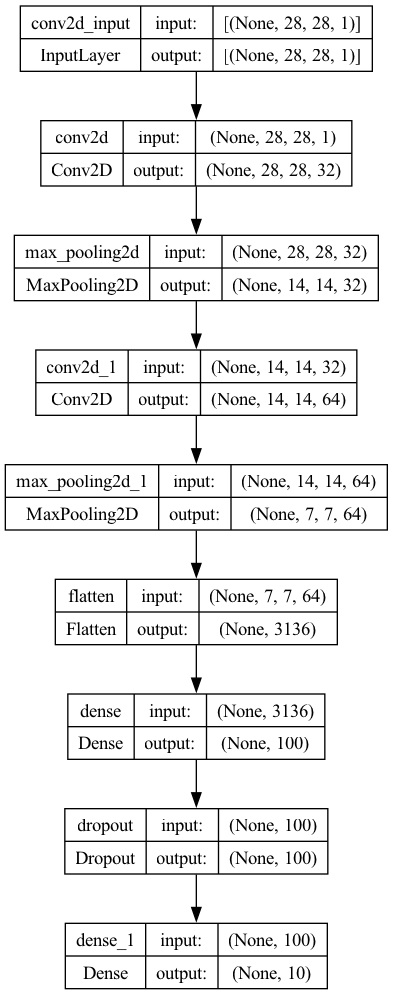

In [10]:
keras.utils.plot_model(model, show_shapes=True)

- 오른쪽의 input, output 상자에서 층으로 입력되는 크기와 출려되는 크기가 나타나기 때문에 이해하기 쉬움
- 지금까지 만든 신경망을 그림으로 다시 살펴보자

![합성곱설명-2-1](./images/convolution-451-1.jpg)

- 합성곱 신경망 모델 구성이 완료됨. 이제 모델 컴파일 및 훈련을 해보자

### 모델 컴파일과 훈련
- 케라스 API의 장점은 모델 종류, 구성 방식에 상관없이 컴파일과 훈련 과정이 같다는 점
- Adam 옵티마이저를 사용하고 ModuleCheckPoint 콜백과 EarlyStopping 콜백을 함께 사용해 조기 종료 기법을 구현

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 29s 19ms/step - loss: 0.5379 - accuracy: 0.8060 - val_loss: 0.3377 - val_accuracy: 0.8775
Epoch 2/20
   6/1500 [..............................] - ETA: 33s - loss: 0.4794 - accuracy: 0.8333

/Users/jeremyshin/.pyenv/versions/3.11.3/envs/hongong/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1500/1500 [==============================] - 34s 23ms/step - loss: 0.3600 - accuracy: 0.8721 - val_loss: 0.2906 - val_accuracy: 0.8917
Epoch 3/20
1500/1500 [==============================] - 35s 23ms/step - loss: 0.3032 - accuracy: 0.8896 - val_loss: 0.2633 - val_accuracy: 0.9028
Epoch 4/20
1500/1500 [==============================] - 37s 24ms/step - loss: 0.2736 - accuracy: 0.9016 - val_loss: 0.2383 - val_accuracy: 0.9139
Epoch 5/20
1500/1500 [==============================] - 37s 25ms/step - loss: 0.2501 - accuracy: 0.9101 - val_loss: 0.2575 - val_accuracy: 0.9057
Epoch 6/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2266 - accuracy: 0.9178 - val_loss: 0.2312 - val_accuracy: 0.9177
Epoch 7/20
1500/1500 [==============================] - 39s 26ms/step - loss: 0.2105 - accuracy: 0.9226 - val_loss: 0.2364 - val_accuracy: 0.9185
Epoch 8/20
1500/1500 [==============================] - 41s 28ms/step - loss: 0.1951 - accuracy: 0.9274 - val_loss: 0.2186 - val_accura

- 훈련 세트의 정확도가 향상된 것을 확인할 수 있음
- 손실 그래프를 그려 조기 종료가 잘 이루어졌는지 확인

In [13]:
import matplotlib.pyplot as plt

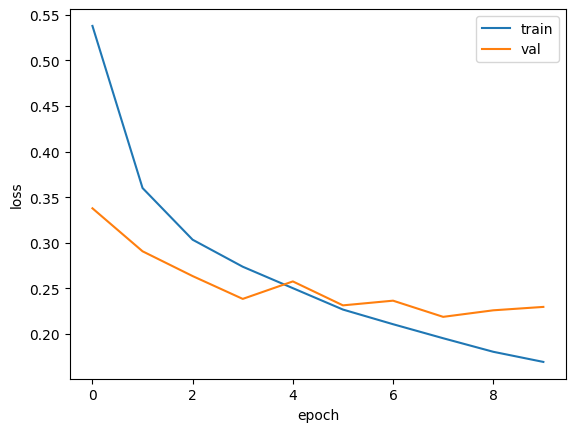

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

- 검증 세트에 대한 손실이 점차 감소하다가 정체되기 시작하고 훈련 세트에 대한 손실은 점점 더 낮아지고 있음
- Early Stopping 클래스에서 restore_best_weights 매개변수를 True로 지정했으므로 현재 model 객체가 최적 모델 파라미터로 복원되어 있음
  - ModelCheckpoint 콜백이 저장한 best-cnn-model.h5 파일을 다시 읽을 필요가 없음
- 세트에 대한 성능을 평가해보자

In [15]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 4s 11ms/step - loss: 0.2186 - accuracy: 0.9231


[0.2186002880334854, 0.9230833053588867]

- fit() 메서드의 출력 중 아홉 번째 에포크의 출력과 동일 (최상의 모델 파라미터로 복원)
- predict() 메서드로 새로운 데이터에 대해 예측을 만들어보자
  - 여기서는 편의상 검증 세트의 첫 번째 샘플을 처음 본 이미지라고 가정
- 맷플롯립은 2차원 이상은 없으므로 (28, 28, 1) 크기를 (28, 28) 크기로 다시 변환

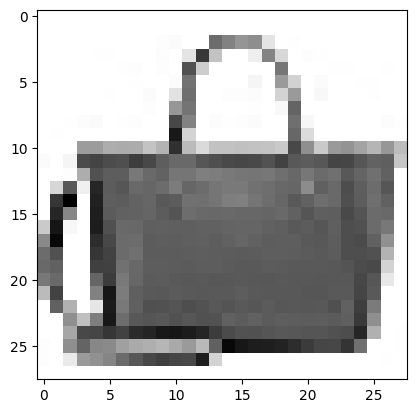

In [16]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()

- 핸드백 이미지 확인
- 모델은 이 이미지에 대해 어떤 예측을 만드는지 확인 : predict() 메서드는 10개 클래스에 대한 예측 확률을 출력

In [17]:
preds = model.predict(val_scaled[0:1])
print(preds)

1/1 [==============================] - 0s 95ms/step
[[2.31388205e-18 4.44399170e-25 7.77937759e-21 2.59144215e-20
  9.34083677e-19 1.56811873e-19 1.28128895e-17 1.33140810e-20
  1.00000000e+00 1.52696693e-21]]


- 여기서 잠깐 :
  - 케라스 fit(), predict(), evaluate() 메서드는 모두 첫 번째 차원이 배치 차원일 것으로 기대
  - (28, 28, 1) 크기를 (1, 28, 28, 1) 크기로 변환해야 함
  - 배열 슬라이싱은 인덱싱과 다르게 선택된 원소가 하나이더라도 전체 차원이 유지되어 (1, 28, 28, 1) 크기를 만듬
- 출력 결과는 9번째 값이 1이고 다른 값은 0에 가까움 (9번째 클래스라고 강하게 주장)
- 막대 그래프로 확인

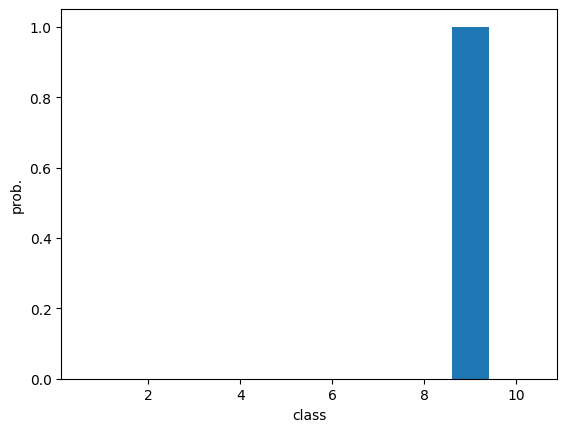

In [18]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

- MNIST 데이터셋 레이블을 다루기 위해 리스트로 저장

In [19]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

- 클래스 리스트가 있으면 레이블 출력이 용이
- preds 배열에서 가장 큰 인덱스를 찾아 classes 리스트이 인덱스로 사용

In [20]:
import numpy as np
print(classes[np.argmax(preds)])

가방


- '가방'으로 잘 예측함
- 마지막으로 맨 처음에 떼어 놓았던 테스트 세트로 합성곱 신경망의 일반화 성능을 가늠해보자
- 이 모델을 실전에 투입했을 때 얻을 수 있는 예상 성능 측정
- 픽셀 값 범위를 0~1로 변경하고 이미지 크기를 (28, 28, 1)로 변경

In [21]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [22]:
# 테스트 세트 성능 측정
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 3s 11ms/step - loss: 0.2416 - accuracy: 0.9163


[0.24157343804836273, 0.9162999987602234]

- 91% 정도의 성능을 기대